## 0. Goal
Vary the inputs to UMAP:
1. Use the VAE trained only on calls

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc
import colorsys
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [5]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [1.5,7]
# what syllable pairs to analyze
v_all = ['v4', 'v5']
# what spectogram datasets to use
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what VAE run to use
vae_suffix = 'VAE2'
vae_run = 'traj_chop_32_1_32'
fd_vae = os.path.join(fd_data, birdID, 'Traj', vae_suffix, vae_run)
# where the VAE latents results are saved
apply_suffix = 'applySyl3_1'
apply_run = f'latent.{vae_run}'
fd_latent = os.path.join(fd_data, birdID, 'Traj', apply_suffix, apply_run)
print(fd_latent)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl3_1/latent.traj_chop_32_1_32


In [6]:
# where to save results
fd_save = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'paramSearch3')
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl3_1/paramSearch3


In [7]:
# grab the info on syllales
fn_merged = os.path.join(fd_latent, f'{birdID}.info_merged.csv')
info_syl = pd.read_csv(fn_merged, index_col=0)
# construct a unique syllable id
info_syl['syl_id'] = [f'{info_syl["fn_wav"][ii]}_{info_syl["s_idx"][ii]}' for ii in info_syl.index]
info_syl = info_syl.reset_index()  # reset index for easy merging later

In [8]:
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'euclidean'}

## 2. UMAP on latents

In [10]:
num_syl = 10000
hdbscan_thre = 0.9
# grab the latent data and info for each call subytpe
fns_latent = sorted(glob.glob(os.path.join(fd_latent, 'latentM.v*.csv')))
# read in all data
latent_comb = np.empty((0, 32))
info_comb = pd.DataFrame()
for v in v_all:
    fn = sorted(glob.glob(os.path.join(fd_latent, f'latentM.{v}.csv')))[0]
    latent = np.loadtxt(fn, delimiter=',')
    fn_info = os.path.join(os.path.dirname(fn), f'info.{v}.csv')
    info = pd.read_csv(fn_info, index_col=0)

    # merge the syllable info to sliding window info
    merged_info = info.merge(info_syl, left_on='ri', right_on='index', how='left')

    #### sample data as UMAP inputs
    info_pass = merged_info[merged_info['hdbscan_prob']>=hdbscan_thre]
    if info_pass.empty:
        continue
    # get unique syllable id
    syl_uniq = sorted(list(set(info_pass['syl_id'])))
    # same syllables
    num_sample = min([num_syl, len(syl_uniq)])
    print(f'Total syllable {len(set(merged_info["syl_id"]))}. Pass threshold {len(syl_uniq)}. Sampled {num_sample}')
    random.seed(1118)
    syl_rd = random.sample(syl_uniq, num_sample)

    # get the latent data
    iwin = merged_info[merged_info['syl_id'].isin(syl_rd)].index
    info_rd = merged_info.iloc[iwin, :]
    latent_rd = latent[iwin, :]
    print(latent_rd.shape, info_rd.shape)

    latent_comb = np.vstack([latent_comb, latent_rd])
    info_comb = pd.concat([info_comb, info_rd], ignore_index=True)

Total syllable 2421. Pass threshold 1228. Sampled 1228
(253072, 32) (253072, 21)
Total syllable 1519. Pass threshold 1359. Sampled 1359
(276462, 32) (276462, 21)


In [11]:
print(latent_comb.shape, info_comb.shape)

(529534, 32) (529534, 21)


In [12]:
umap_model, embed = vae_goffinet.ZZ_runUMAP_v1(latent_comb, param_umap, random_state=1118, meta_info=info_comb)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sat Jul 26 14:07:54 2025 Construct fuzzy simplicial set
Sat Jul 26 14:07:54 2025 Finding Nearest Neighbors
Sat Jul 26 14:07:54 2025 Building RP forest with 41 trees
Sat Jul 26 14:08:03 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Sat Jul 26 14:08:34 2025 Finished Nearest Neighbor Search
Sat Jul 26 14:08:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Jul 26 14:14:42 2025 Finished embedding


In [14]:
# save the embedding
fn_embed = os.path.join(fd_save, f'{birdID}.vaeVall.hop1ms.embedding.csv')
embed.to_csv(fn_embed)

In [15]:
print(fn_embed)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl3_1/paramSearch3/pair5RigCCU29.vaeVall.hop1ms.embedding.csv


Text(0, 0.5, 'UMAP axis 2')

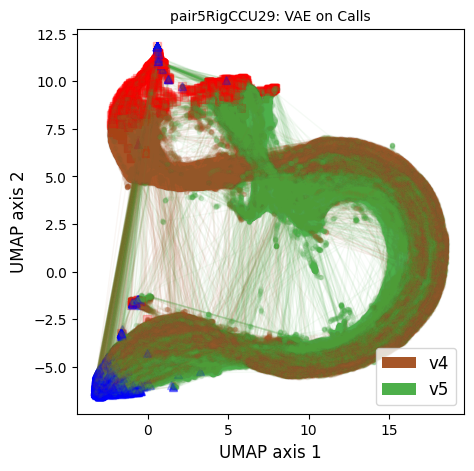

In [17]:
#### plot results, different color for different call subtypes
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(v_all, col_full[0:len(v_all)]))
# get the syl id
syl_comb = list(set(info_comb['syl_id']))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si in range(len(syl_comb)):
    ss = syl_comb[si]
    embed_s = embed[embed['syl_id']==ss]
    embed_s.index = range(embed_s.shape[0])
    x = np.array(embed_s['umap1'])
    y = np.array(embed_s['umap2'])
    v = embed_s['call_subtype'][0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.05)
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.25)
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.25)
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax.legend(handles=legends, loc='lower right', fontsize=12)
ax.set_title(f'{birdID}: VAE on Calls', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)

In [73]:
## find the index of a specific syllable
syl_to_find = '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00028_00009_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_123106_chan0.wav_16'
syl_comb.index(syl_to_find)

2475